# The Merits of Clustering SHAP Values - an Illustrative Example

## Set-up

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from sklearn.cluster import KMeans, AgglomerativeClustering, Birch, DBSCAN
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from umap import UMAP

# work around for skrules import error
import six
import sys
sys.modules['sklearn.externals.six'] = six
from skrules import SkopeRules

In [2]:
plt.style.use("style.mplstyle")
shap.initjs()

### Configure Notebook Parameters

In [3]:
n_clusters_per_class = 3
seed = 1

# for plotting
alpha = 0.5
size = 15

## Simulate Dataset

[`make_classification` docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification)

In [4]:
np.random.seed(seed)

X, y = make_classification(
    n_samples=1000,
    n_features=50,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=n_clusters_per_class,
    weights=None,
    flip_y=0,
    hypercube=True,
    class_sep=1.9,
    shift=np.random.random(50) * 3 - 1.5,
    scale=np.random.random(50) * 2,
    random_state=seed,
    shuffle=False
)

## Train Classifier

In [5]:
m = lgb.LGBMClassifier(random_state=seed)
m.fit(X, y)

LGBMClassifier(random_state=1)

In [6]:
y_pred = m.predict(X)
acc = accuracy_score(y, y_pred)
acc

1.0

### Compute SHAP Values

In [7]:
explainer = shap.Explainer(m, random_state=seed)
shap_values = explainer(X)
sv = shap_values.values[:, :, 1]

### Compare SHAP Values with Raw Values

In [8]:
# prepare data for visualisation
df_sv = pd.DataFrame(sv)
df_sv.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_sv["variable value"] = "shap"

df_raw = pd.DataFrame(X)
df_raw.columns = [f"feat{n}" for n in range(X.shape[1])]
df_sv["y"] = y
df_raw["variable value"] = "raw"

df_all = pd.concat([df_raw, df_sv], axis=0, ignore_index=True)

# convert to long format
l = pd.melt(
    df_all,
    id_vars=["y", "variable value"],
    value_vars=[f"feat{n}" for n in range(X.shape[1])],
)
l["variable"] = l["variable"].str[4:]

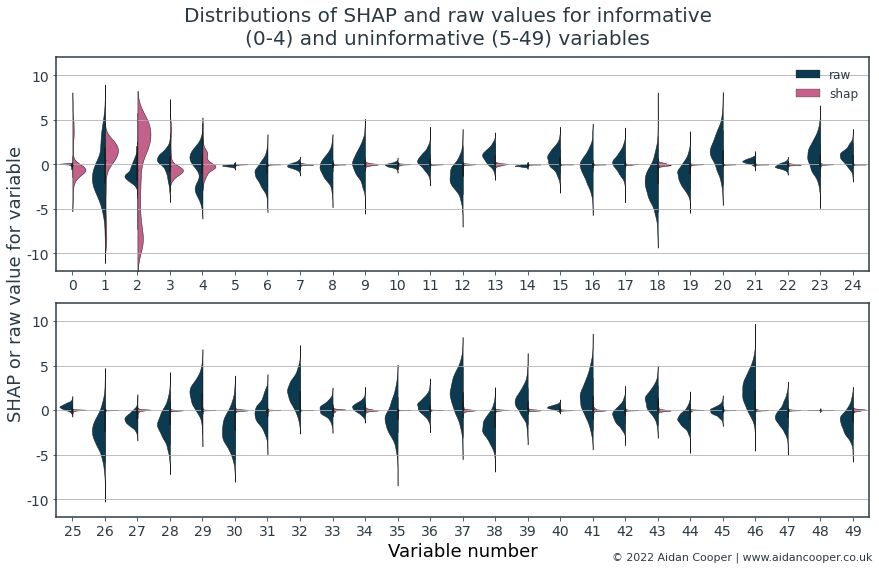

In [9]:
fig, ax = plt.subplots(2, 1)

sns.violinplot(
    x="variable",
    y="value",
    data=l.iloc[:50000],
    hue="variable value",
    ax=ax[0],
    linewidth=0.5,
    split=True,
    scale="width",
)
sns.violinplot(
    x="variable",
    y="value",
    data=l.iloc[50000:],
    hue="variable value",
    ax=ax[1],
    linewidth=0.5,
    split=True,
    scale="width",
)

lim = np.round(l["value"].abs().max()) + 2
for a in (0, 1):
    ax[a].set_ylim(-lim, lim)
    ax[a].grid(axis="y")
    ax[a].set_xlabel("")
    ax[a].set_ylabel("")
    ax[a].legend().remove()
ax[1].set_xlabel("Variable number")
ax[0].legend()

fig.text(
    -0.01,
    0.5,
    "SHAP or raw value for variable",
    va="center",
    rotation="vertical",
    fontsize=18,
)
fig.suptitle(
    "Distributions of SHAP and raw values for informative\n(0-4) and uninformative (5-49) variables",
    fontsize=20,
)
fig.text(
    0.69,
    0.02,
    "© 2022 Aidan Cooper | www.aidancooper.co.uk",
    fontsize=11,
)
fig.tight_layout()

fig.savefig("plots/distributions.png")

## Dimensionality Reduction

In [10]:
def umap_embedding(
    values: np.array,
    n_components: int = 2,
    n_neighbors: int = 200,
    min_dist: float = 0.0,
    random_state: int = seed,
):
    embedding = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        random_state=random_state,
    ).fit_transform(values)
    return embedding

### Using Raw Values

In [11]:
# for class colours in scatter plots
c = ["#d45087"] * len(y)  # pink
for i in range(len(y)):
    if y[i] == 1:
        c[i] = "#003f5c"  # blue

In [12]:
X_2d = umap_embedding(X)

The TBB threading layer requires TBB version 2021 update 1 or later i.e., TBB_INTERFACE_VERSION >= 12010. Found TBB_INTERFACE_VERSION = 11002. The TBB threading layer is disabled.


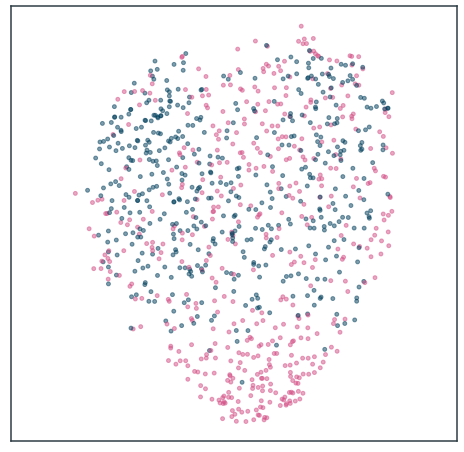

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(X_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([]);

### Using SHAP Values

In [14]:
sv_2d = umap_embedding(sv)

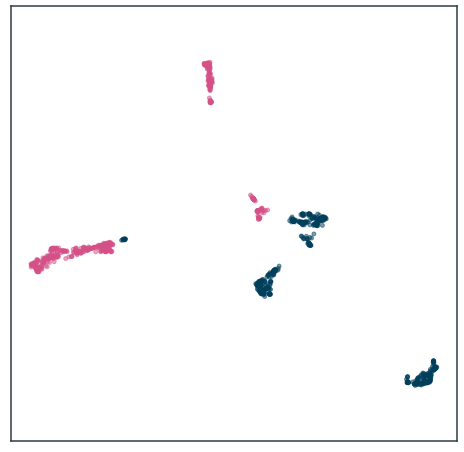

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
sns.regplot(
    x="A",
    y="B",
    data=pd.DataFrame(sv_2d, columns=["A", "B"]),
    fit_reg=False,
    ax=ax,
    scatter_kws={"alpha": alpha, "s": size, "color": c},
)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([]);

## Clustering

In [16]:
def cluster_labels(embedding: np.array, n_clusters: int, random_state: int = seed):
    return DBSCAN(eps=1.5, min_samples=20).fit(embedding).labels_

In [17]:
def get_cmap(cluster_labels):
    colours = ["#ffa600", "#665191", "#ff7c43", "#2f4b7c", "#f95d6a", "#a05195"]
    cmap = []
    for l in cluster_labels:
        if l == -1:
            cmap.append("grey")
        else:
            cmap.append(colours[l])
    return cmap

### Using SHAP Embedding

In [18]:
sv_2d_labels = cluster_labels(sv_2d, n_clusters=n_clusters_per_class * 2)
sv_cmap = get_cmap(sv_2d_labels)

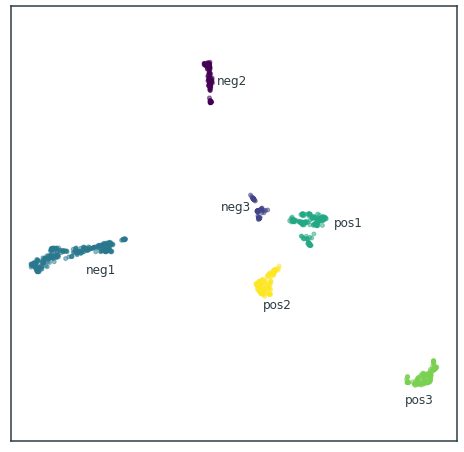

In [57]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv_2d_labels, s=size, alpha=alpha)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.annotate("neg1", (0.8, 3), fontsize=12)
ax.annotate("neg2", (9.1, 15), fontsize=12)
ax.annotate("neg3", (9.3, 7), fontsize=12)
ax.annotate("pos1", (16.5, 6), fontsize=12)
ax.annotate("pos2", (12, 0.8), fontsize=12)
ax.annotate("pos3", (21, -5.2), fontsize=12);

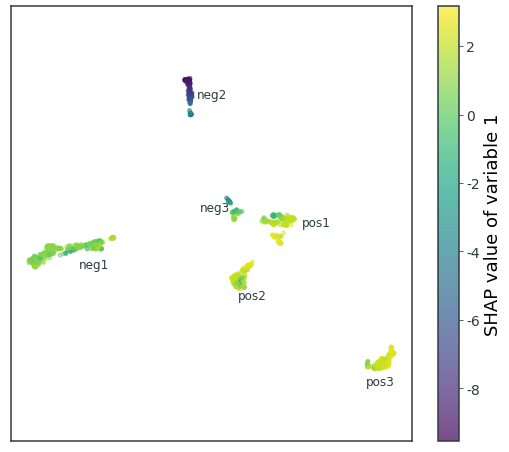

In [94]:
v = 1

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=sv[:, v], s=size, alpha=alpha)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.annotate("neg1", (0.8, 3), fontsize=12)
ax.annotate("neg2", (9.1, 15), fontsize=12)
ax.annotate("neg3", (9.3, 7), fontsize=12)
ax.annotate("pos1", (16.5, 6), fontsize=12)
ax.annotate("pos2", (12, 0.8), fontsize=12)
ax.annotate("pos3", (21, -5.2), fontsize=12)

cbar = fig.colorbar(im)
cbar.set_label(f"SHAP value of variable {v}")
cbar.set_alpha(0.7)
cbar.draw_all();

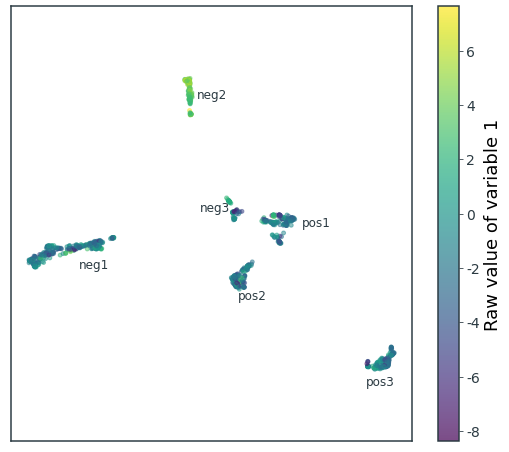

In [93]:
v = 1

fig, ax = plt.subplots(figsize=(9, 8))
im = ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=X[:, v], s=size, alpha=alpha)
ax.axis("equal")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.set_yticks([])
ax.annotate("neg1", (0.8, 3), fontsize=12)
ax.annotate("neg2", (9.1, 15), fontsize=12)
ax.annotate("neg3", (9.3, 7), fontsize=12)
ax.annotate("pos1", (16.5, 6), fontsize=12)
ax.annotate("pos2", (12, 0.8), fontsize=12)
ax.annotate("pos3", (21, -5.2), fontsize=12)

cbar = fig.colorbar(im)
cbar.set_label(f"Raw value of variable {v}")
cbar.set_alpha(0.7)
cbar.draw_all();

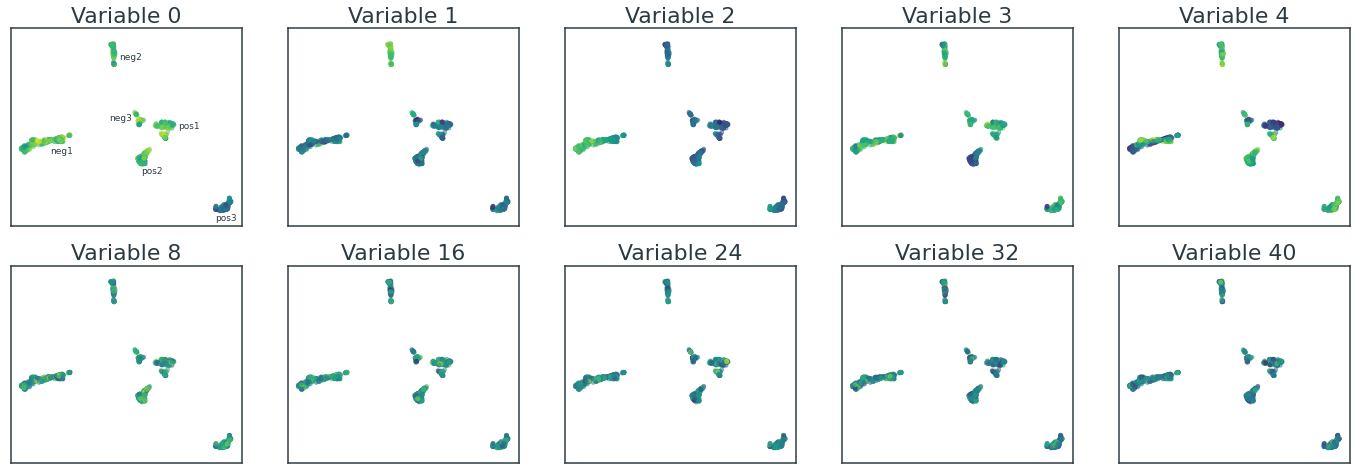

In [89]:
vs = [0, 1, 2, 3, 4, 8, 16, 24, 32, 40]

fig, axes = plt.subplots(2, 5, figsize=(24, 8))
axes = axes.flatten()

for ax, v in zip(axes, vs):
    im = ax.scatter(sv_2d[:, 0], sv_2d[:, 1], c=X[:, v], s=size, alpha=alpha)
    ax.axis("equal")
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"Variable {v}")
    
    if v == 0:
        ax.annotate("neg1", (0.8, 3), fontsize=9)
        ax.annotate("neg2", (9.3, 14.5), fontsize=9)
        ax.annotate("neg3", (8.1, 7), fontsize=9)
        ax.annotate("pos1", (16.5, 6), fontsize=9)
        ax.annotate("pos2", (12, 0.5), fontsize=9)
        ax.annotate("pos3", (21, -5.2), fontsize=9)

fig.savefig("plots/temp.png")

## Cluster Descriptions

In [21]:
df_X = df_raw.drop("variable value", axis=1)

In [22]:
def skoperules_models(
    X: pd.DataFrame,
    y: np.array,
    labels: np.array,
    n_estimators: int = 10,
    recall_min: float = 0.2,
    max_depth: int = 4,
    max_depth_duplication: int = 4,
    max_samples: float = 1.0,
    random_state: int = seed,
):
    X["cluster"] = labels
    sr_models = {}
    for cluster in X["cluster"].value_counts().index.sort_values():
        Xc = X.drop("cluster", axis=1)
        yc = (X["cluster"] == cluster) * 1
        sr = SkopeRules(
            feature_names=Xc.columns,
            random_state=random_state,
            n_estimators=n_estimators,
            recall_min=recall_min,
            max_depth=max_depth,
            max_depth_duplication=max_depth_duplication,
            max_samples=max_samples,
            max_features=None
        )
        sr.fit(Xc, yc)
        sr_models[cluster] = sr
    return sr_models

In [23]:
sv_models = skoperules_models(df_X, y, sv_2d_labels)

In [24]:
for cluster in sv_models.keys():
    print(f"Cluster {cluster}")
    if len(sv_models[cluster].rules_) == 0:
        print("N/A")
    else:
        for i, rule in enumerate(sv_models[cluster].rules_):
            if i == 0:
                for line in rule[0].split(" and "):
                    print(f"\t{line}")
                print(f"Precision: {rule[1][0]:.4f}")
                print(f"Recall   : {rule[1][1]:.4f}")
    print()

Cluster 0
	feat1 > 2.3398897647857666
	feat2 <= -0.02651633322238922
	feat4 > -1.4165911078453064
	feat7 <= 0.6505580246448517
Precision: 1.0000
Recall   : 0.9690

Cluster 1
	feat0 > 0.12441839650273323
	feat2 <= -0.7795118987560272
	feat29 > -0.09384323470294476
	feat3 > -0.3971446752548218
Precision: 0.8750
Recall   : 0.3443

Cluster 2
	feat0 > -0.050614044070243835
	feat1 <= 2.6362096071243286
	feat2 > -0.7123425304889679
	feat3 > -1.0100204646587372
Precision: 0.9969
Recall   : 0.9694

Cluster 3
	feat0 <= 0.12530316784977913
	feat2 <= -0.7569182813167572
	feat3 > -1.0546936392784119
	feat4 <= -1.619143009185791
Precision: 0.9669
Recall   : 0.7766

Cluster 4
	feat0 <= -0.041219551116228104
	feat3 <= 1.631798505783081
	feat3 > -2.1033881306648254
	feat34 > -0.8628552854061127
Precision: 0.9925
Recall   : 0.8926

Cluster 5
	feat0 > -0.06411126255989075
	feat1 <= 2.627581834793091
	feat3 <= -0.8852411806583405
	feat4 > -1.5127198696136475
Precision: 1.0000
Recall   : 0.8562

